In [58]:
import csv

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [59]:
# Specify data paths
dataset = 'new_gestures.csv'
model_save_path = 'keypoint_classifier.hdf5'
tflite_save_path = 'keypoint_classifier.tflite'

# Set number of classes

In [60]:
# Change training classes if necessary
NUM_CLASSES = 12

# Dataset reading

In [61]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [62]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int32), array([656, 581, 945, 758, 729, 615, 746, 519, 746, 718, 429, 513]))


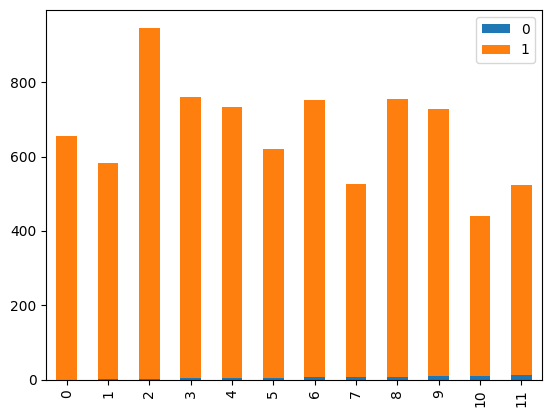

In [64]:
# Classes count
counts = np.unique(y_dataset, return_counts=True)
df = pd.DataFrame(counts)
df.T.plot(kind="bar", stacked=True)
print(counts)

# Model building

In [65]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.0),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.0),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.0),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [66]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_33 (Dropout)        (None, 42)                0         
                                                                 
 dense_44 (Dense)            (None, 32)                1376      
                                                                 
 dropout_34 (Dropout)        (None, 32)                0         
                                                                 
 dense_45 (Dense)            (None, 32)                1056      
                                                                 
 dropout_35 (Dropout)        (None, 32)                0         
                                                                 
 dense_46 (Dense)            (None, 16)                528       
                                                                 
 dense_47 (Dense)            (None, 12)              

In [67]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False, save_best_only=True)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=50, verbose=1)

In [68]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [69]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
92/94 [============================>.] - ETA: 0s - loss: 2.1350 - accuracy: 0.3657
Epoch 1: val_loss improved from inf to 1.62501, saving model to keypoint_classifier.hdf5
94/94 [==============================] - 2s 8ms/step - loss: 2.1269 - accuracy: 0.3681 - val_loss: 1.6250 - val_accuracy: 0.5023
Epoch 2/1000
66/94 [====================>.........] - ETA: 0s - loss: 1.2530 - accuracy: 0.6887

/usr/local/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


89/94 [===========================>..] - ETA: 0s - loss: 1.1082 - accuracy: 0.7456
Epoch 2: val_loss improved from 1.62501 to 0.55718, saving model to keypoint_classifier.hdf5
94/94 [==============================] - 0s 4ms/step - loss: 1.0821 - accuracy: 0.7543 - val_loss: 0.5572 - val_accuracy: 0.9251
Epoch 3/1000
79/94 [========================>.....] - ETA: 0s - loss: 0.3334 - accuracy: 0.9693
Epoch 3: val_loss improved from 0.55718 to 0.18672, saving model to keypoint_classifier.hdf5
94/94 [==============================] - 0s 4ms/step - loss: 0.3121 - accuracy: 0.9717 - val_loss: 0.1867 - val_accuracy: 0.9854
Epoch 4/1000
74/94 [======================>.......] - ETA: 0s - loss: 0.1269 - accuracy: 0.9867
Epoch 4: val_loss improved from 0.18672 to 0.08773, saving model to keypoint_classifier.hdf5
94/94 [==============================] - 0s 3ms/step - loss: 0.1185 - accuracy: 0.9878 - val_loss: 0.0877 - val_accuracy: 0.9935
Epoch 5/1000
75/94 [======================>.......] - ETA: 

In [70]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [71]:
# Model evaluation
# TODO Test on loaded model
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=64)

32/32 [==============================] - 0s 2ms/step - loss: 1.3271e-05 - accuracy: 1.0000


In [56]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 100ms/step
[7.1241796e-20 6.8794399e-19 1.3152650e-19 1.1814495e-08 3.3296141e-18
 5.0002588e-22 2.5025160e-09 5.2900985e-14 5.7007183e-24 1.0000000e+00
 3.6295904e-11 1.9533433e-26]
9


# Confusion matrix

63/63 [==============================] - 0s 2ms/step


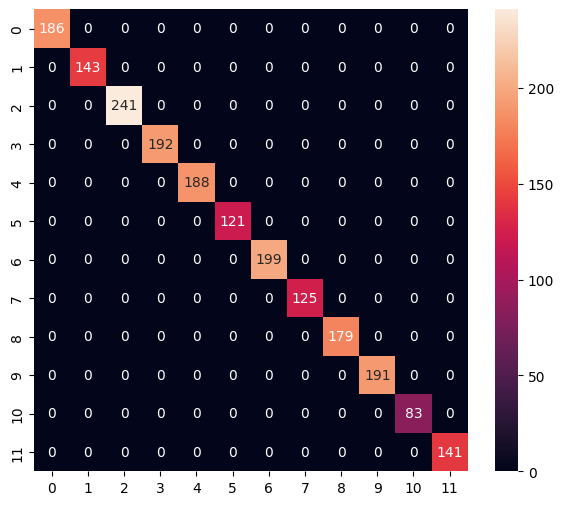

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       186
           1       1.00      1.00      1.00       143
           2       1.00      1.00      1.00       241
           3       1.00      1.00      1.00       192
           4       1.00      1.00      1.00       188
           5       1.00      1.00      1.00       121
           6       1.00      1.00      1.00       199
           7       1.00      1.00      1.00       125
           8       1.00      1.00      1.00       179
           9       1.00      1.00      1.00       191
          10       1.00      1.00      1.00        83
          11       1.00      1.00      1.00       141

    accuracy                           1.00      1989
   macro avg       1.00      1.00      1.00      1989
weighted avg       1.00      1.00      1.00      1989



In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [73]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

/usr/local/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [74]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/kf/9vc6x6n97q942grwf1zf0trw0000gn/T/tmprwcwktjl/assets


INFO:tensorflow:Assets written to: /var/folders/kf/9vc6x6n97q942grwf1zf0trw0000gn/T/tmprwcwktjl/assets
2023-12-12 11:09:35.718578: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-12 11:09:35.718609: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-12 11:09:35.718935: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/kf/9vc6x6n97q942grwf1zf0trw0000gn/T/tmprwcwktjl
2023-12-12 11:09:35.721146: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-12 11:09:35.721162: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/kf/9vc6x6n97q942grwf1zf0trw0000gn/T/tmprwcwktjl
2023-12-12 11:09:35.728546: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-12-12 11:09:35.823017: I tensorflow/cc/saved_model/loader.cc:217] Running initialization

8280

## Inference test

In [20]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [21]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [22]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [23]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 1.19 ms, sys: 2.14 ms, total: 3.32 ms
Wall time: 5.37 ms


In [24]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.7255490e-03 5.0721752e-08 4.1267772e-06 9.6219352e-05 1.4876920e-07
 9.9813098e-01 8.2815510e-17 2.6720117e-09 8.2250688e-13 4.1762651e-05
 3.0143952e-16 1.1715595e-06]
5


## Download model

In [25]:
!zip -r model.zip keypoint_classifier  

	zip warning: name not matched: keypoint_classifier

zip error: Nothing to do! (try: zip -r model.zip . -i keypoint_classifier)




---


# ❗️Hyperparameters Tuning

In [26]:
%load_ext tensorboard
from tensorboard.plugins.hparams import api as hp

In [27]:
# Init parameters to tune
HP_NUM_UNITS_1 = hp.HParam('num_units_1', hp.Discrete([16, 32, 64]))
HP_NUM_UNITS_2 = hp.HParam('num_units_2', hp.Discrete([8, 16, 32]))
HP_NUM_UNITS_3 = hp.HParam('num_units_3', hp.Discrete([8, 16, 32]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.0, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'accuracy'

In [28]:
with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS_1,HP_NUM_UNITS_2,HP_NUM_UNITS_3, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [29]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False, save_best_only=True)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=15, verbose=1)

In [30]:
def train_test_model(hparams):

  model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS_1], activation='relu'),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS_2], activation='relu'),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS_3], activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])
  
  model.compile(
    optimizer=hparams[HP_OPTIMIZER],
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
  
  cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False, save_best_only=True)

  model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[
               cp_callback,
               es_callback,
               ]
  ) 

  # Load model with best accuracy
  model = tf.keras.models.load_model(model_save_path)

  _, accuracy = model.evaluate(X_test, y_test)
  return accuracy

def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [31]:
session_num = 0

for num_units_1 in HP_NUM_UNITS_1.domain.values:
  for num_units_2 in HP_NUM_UNITS_2.domain.values:
    for num_units_3 in HP_NUM_UNITS_3.domain.values:
      for dropout_rate in np.arange(HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value, 0.1):
        for optimizer in HP_OPTIMIZER.domain.values:
          hparams = {
              HP_NUM_UNITS_1: num_units_1,
              HP_NUM_UNITS_2: num_units_2,
              HP_NUM_UNITS_3: num_units_3,
              HP_DROPOUT: dropout_rate,
              HP_OPTIMIZER: optimizer,
          }
          run_name = "run-%d" % session_num
          print('--- Starting trial: %s' % run_name)
          print({h.name: hparams[h] for h in hparams})
          run('logs/hparam_tuning/' + run_name, hparams)
          session_num += 1

--- Starting trial: run-0
{'num_units_1': 16, 'num_units_2': 8, 'num_units_3': 8, 'dropout': 0.0, 'optimizer': 'adam'}
Epoch 1/50
82/88 [==========================>...] - ETA: 0s - loss: 2.3914 - accuracy: 0.2003
Epoch 1: val_loss improved from inf to 2.16656, saving model to keypoint_classifier.hdf5
88/88 [==============================] - 2s 6ms/step - loss: 2.3804 - accuracy: 0.2038 - val_loss: 2.1666 - val_accuracy: 0.2591
Epoch 2/50
81/88 [==========================>...] - ETA: 0s - loss: 2.0078 - accuracy: 0.2859

/usr/local/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 2.16656 to 1.80112, saving model to keypoint_classifier.hdf5
88/88 [==============================] - 0s 3ms/step - loss: 1.9927 - accuracy: 0.2898 - val_loss: 1.8011 - val_accuracy: 0.3306
Epoch 3/50
76/88 [========================>.....] - ETA: 0s - loss: 1.7046 - accuracy: 0.3694
Epoch 3: val_loss improved from 1.80112 to 1.58134, saving model to keypoint_classifier.hdf5
88/88 [==============================] - 0s 4ms/step - loss: 1.6972 - accuracy: 0.3735 - val_loss: 1.5813 - val_accuracy: 0.4258
Epoch 4/50
83/88 [===========================>..] - ETA: 0s - loss: 1.5029 - accuracy: 0.4162
Epoch 4: val_loss improved from 1.58134 to 1.38424, saving model to keypoint_classifier.hdf5
88/88 [==============================] - 0s 3ms/step - loss: 1.4927 - accuracy: 0.4203 - val_loss: 1.3842 - val_accuracy: 0.4796
Epoch 5/50
83/88 [===========================>..] - ETA: 0s - loss: 1.3040 - accuracy: 0.5296
Epoch 5: val_loss improved from 1.38424 to 1.19919,

KeyboardInterrupt: 

In [ ]:
# !ATTENTION! Works only in Colab
%tensorboard --logdir logs/hparam_tuning

In [ ]:
!rm -rf logs